## 0. Setting up the Environment


In [1]:
## impoort labaries 
import os 
import cv2
import mat73
import time
import pandas as pd
import numpy as np 
import seaborn as sns
import skimage
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage.transform import resize
from keras.models import Sequential
from tensorflow.keras import optimizers
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D

## 1. Data Importing 

In [2]:
SIZE_X = 128
SIZE_Y = 128

aug_train_DF = pd.read_pickle(r"../../../Datasets/Dataset_B/aug_train_DF_{}.pkl".format(SIZE_X))
aug_val_DF = pd.read_pickle(r"../../../Datasets/Dataset_B/aug_val_DF_{}.pkl".format(SIZE_X))
aug_test_DF = pd.read_pickle(r"../../../Datasets/Dataset_B/aug_test_DF_{}.pkl".format(SIZE_X))

In [3]:
## Combain the df with the Pitutary & Meningioma types with the dataframe of the Glioma grades (I, II,, IV).

pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).sample(5)

,PID,Label,Image,File
5530,HF1345,Glioma II,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
10097,107429,Pituitary,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1183.mat
8817,900-00-5379,Glioma VI,"[[10, 1, 10, 6, 10, 12, 4, 6, 4, 9, 6, 6, 14, ...",D:\Datasets\manifest-tXudPFfp43472957274060920...
6015,107743,Pituitary,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",949.mat
3123,HF1097,Glioma VI,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...


C:\Users\Ma7moud\anaconda3\envs\T-UNet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


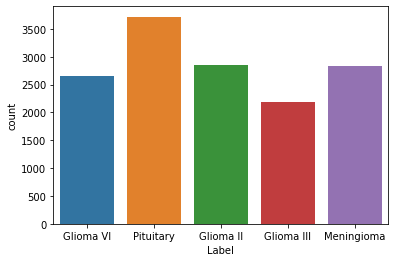

In [4]:
sns.countplot(pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).Label)
plt.show()

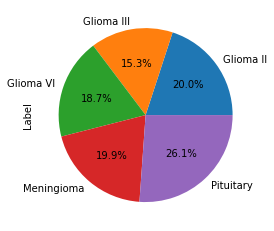

In [5]:
data = pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

## 2. Data-Preprocessing 

### 2.1 Image Resizing 


### 2.2 Data Augmentation

### 2.3 Grayscale to RGB

In [6]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')

In [7]:
aug_train_DF["Image"] = aug_train_DF["Image"].apply(normalize)
aug_val_DF["Image"] = aug_val_DF["Image"].apply(normalize)
aug_test_DF["Image"] = aug_test_DF["Image"].apply(normalize)

KeyboardInterrupt: 

### 2.4 Splitting Data into Train, Test, and Validation Sets

In [ ]:
y_train = aug_train_DF["Label"]
X_train = aug_train_DF['Image'].tolist()
X_train = np.array(X_train).reshape(-1, SIZE_X, SIZE_Y, 3)


y_val = aug_val_DF["Label"]
X_val = aug_val_DF['Image'].tolist()
X_val = np.array(X_val).reshape(-1, SIZE_X, SIZE_Y, 3)

y_test = aug_test_DF["Label"]
X_test = aug_test_DF['Image'].tolist()
X_test = np.array(X_test).reshape(-1, SIZE_X, SIZE_Y, 3)


In [ ]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

### 2.5 One-Hot Encode the labels 

In [ ]:
# saving a copy of the testing labels before one hot encoding
y_test_eval = y_test
# one hot endcoding the labels 
y_train = pd.get_dummies(y_train)
y_test  = pd.get_dummies(y_test)
y_val   = pd.get_dummies(y_val)

In [ ]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_test shape :",X_test.shape," | y_test shape: ", y_test.shape)
print("X_val shape  :",X_val.shape," | y_val shape : ", y_val.shape)
print("\nTotal number: {}".format(len(aug_train_DF)+len(aug_val_DF)+len(aug_test_DF)))

In [ ]:
y_test

In [ ]:
## This Dictionary is used to decode the model's predicted values.  
decode_dict = {0 : "Glioma II", 1 : "Glioma III", 2 : "Glioma VI", 3: "Meningioma", 4: "Pituitary"}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
##  Creating a Pie chart illustrating the percentage of the train, validation, test sets.
Data = np.array([len(y_train), len(y_test), len(y_val)])
mylabels = ["Test Set", "Test Set", "Validation Set"]
plt.figure(figsize=(13, 8))
plt.pie(Data, labels = mylabels, autopct="%.1f%%", )
plt.legend()
plt.show() 

## 3. Models Creation


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D, Input, Lambda
import tensorflow as tf
import time
from tensorflow.keras import optimizers
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from glob import glob

X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

ResNet50 = ResNet50(include_top=False, weights=None, input_shape = (SIZE_X, SIZE_Y, 3))

for layer in ResNet50.layers:
    layer.trainable = False

# Dense Lyers
x = Flatten()(ResNet50.output)
outLayers = Dense(5, activation='softmax')(x)

m1 = Model(inputs = ResNet50.input, outputs = outLayers)

m1.summary()
m1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 4. Model Training


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 15 )

m1.fit(X_train,y_train,epochs=150, validation_data=(X_val,y_val), callbacks = [early_stop], verbose=1)

In [ ]:
# Get training history
metrics = pd.DataFrame(m1.history.history)

In [ ]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [ ]:
print(results)

In [ ]:
# Save The Trained model along with it training history   
Accuracy = m1.evaluate(X_test, y_test)[-1]
name = str(round(Accuracy, 4))

metrics.to_pickle(os.path.join(results, name+'.pkl'))
m1.save(os.path.join(weights, name + '.h5'))

In [ ]:
## Dispaly the plot of 
rows = 2
columns = 1
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.show()

  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 2)
plt.plot(metrics['accuracy'])
plt.plot(metrics['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'acc_epoch.png'))
plt.show()



In [ ]:
## Get the 
predict_x = m1.predict(X_test) 
predictions = np.argmax(predict_x,axis=1) 

In [ ]:
# Decode the Model's predections  (from [0,1,0,2..] to ['Glioma','Meningioma'...]) of the Test set using the the dictionary 'decode_dict' 
predictions = np.vectorize(decode_dict.get)(predictions)

In [ ]:
print(classification_report(y_test_eval, predictions))

In [ ]:
labels = sorted(["Glioma II", "Glioma III", "Glioma VI", "Meningioma", "Pituitary"])

cm = pd.DataFrame(confusion_matrix(y_test_eval, predictions), index=labels, columns=labels)
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, cmap="PuBu",fmt = 'd')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(os.path.join(results, 'confusion_matrix.png'))
plt.show()